# Algoritmo di Shor

## Introduzione

L'algoritmo di Shor è un algoritmo quantistico sviluppato dal matematico Peter Shor nel 1994, famoso per la sua capacità di scomporre rapidamente numeri interi in fattori primi. A differenza degli algoritmi classici, che richiedono un tempo esponenziale per eseguire questa operazione, l'algoritmo di Shor sfrutta le proprietà della meccanica quantistica per ridurre drasticamente il tempo di calcolo, rendendo possibile la fattorizzazione in tempo polinomiale. Questo lo rende particolarmente rilevante per la crittografia moderna, poiché potrebbe compromettere la sicurezza di sistemi come RSA, che si basano proprio sulla difficoltà della fattorizzazione.

### Versione delle librerie Qiskit usate

In [1]:
# Print qiskit library version
import qiskit
import qiskit_aer
import qiskit_ibm_runtime

print(f"Qiskit Version: {qiskit.__version__}")
print(f"Qiskit-aer Version: {qiskit_aer.__version__}")
print(f"Qiskit-ibm-runtime Version: {qiskit_ibm_runtime.__version__}")


Qiskit Version: 1.3.2
Qiskit-aer Version: 0.16.0
Qiskit-ibm-runtime Version: 0.34.0


### Librerie necessarie per l'esecuzione dell'algoritmo

In [2]:
#Import all the needed library

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.circuit.library import QFT, UnitaryGate, IntegerComparator, CDKMRippleCarryAdder, PhaseEstimation
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

import numpy as np
from math import gcd, log2, ceil
from random import randint
from fractions import Fraction


In [3]:
# Load the ibm token if needed

def setup_token():
    print("Loading Token")
    file = open("token_loaded.txt", "r")
    token_loaded = file.read()
    file.close()
    if not token_loaded == 'True':
        print("Not Loaded")
        file = open("token.txt", "r")
        ibm_token = file.read()
        file.close()
        print("Read Token from file")
        QiskitRuntimeService.save_account( ibm_token, channel = 'ibm_quantum', overwrite=True )
        file = open("token_loaded.txt", "w")
        file.write("True")
        file.close()
        print("Loaded")
    print("Done")

setup_token()


Loading Token
Done


In [4]:
# shor number theory

def period_to_factor(N:int, a:int , r:int ):
    """
    Function to convert period into factor.
    Args:
        N (int): Number that needs to be factorized.
        a (int): Number coprime with N of witch we know the order.
        r (int): Order of the number a.
    Returns:
        Tuple(int , int): The 2 factor making-up the number N
    """

    if r % 2 == 0 and pow(a, r // 2, N) not in [-1 % N, 1]:
        p = gcd(pow(a, r // 2, N) + 1, N)
        q = gcd(pow(a, r // 2, N) - 1, N)
        return p, q
    else:
        raise Exception("Not a valid period")


In [5]:
# find a (coprime number for N)

def find_a(N:int) -> int:
    """
    Function to find a coprime number with N.
    Args:
        N (int): Number on which the coprime number will be calculated.
    Returns:
        int: The coprime number with N.
    """

    while True:
        a = randint(2, N - 1)  # Random integer in [2, N-1]
        d = gcd(a, N)
        if d == 1:
            return a  # Valid a found


In [6]:
# from phase to period

def post_process_qpe_results(counts, N, a):
    """
    Post-processes the QPE measurement results to determine the order r.
    Args:
        counts (dict): Measurement results from the QPE circuit.
        N (int): The modulus.
        a (int): The multiplier, coprime with N.
    Returns:
        int: The order r of a modulo N.
    """

    # Find the most frequent measurement result
    most_frequent_result = max(counts, key=counts.get)

    # Convert the binary result to an integer s
    s = int(most_frequent_result, 2)

    # Get number of counting qbits
    n_counting = len(most_frequent_result)

    # Approximate the phase phi = s / 2^n
    phi = s / (2 ** n_counting)

    # Use the continued fractions algorithm to approximate phi as k/r
    fraction = Fraction(phi).limit_denominator(N)
    k, r = fraction.numerator, fraction.denominator

    # Verify if r is the order of a modulo N
    if pow(a, r, N) == 1 and r % 2 == 0 and pow(a, r // 2, N) not in [-1 % N, 1]:
        return r
    else:
        # If r is not the order, try multiples of r
        for multiple in range(2, N):
            candidate_r = r * multiple
            if pow(a, candidate_r, N) == 1:
                return candidate_r
    raise ValueError(f"Can't find r = {r}")

In [7]:
# phase estimator

def construct_U_gate(a_power, N):
    """
    Constructs the unitary gate for the operation U: |x> → |(a^power * x) mod N>.
    For x >= N, U leaves |x> unchanged.
    """
    m = ceil(log2(N))
    size = 2 ** m
    matrix = np.eye(size, dtype=complex)
    for x in range(N):
        y = (a_power * x) % N
        matrix[:, [x, y]] = matrix[:, [y, x]]
    return UnitaryGate(matrix, label=f"U^{a_power}")

def quantum_phase_estimation(N, a, n_counting=None):
    """
    Constructs the Quantum Phase Estimation circuit for the unitary U: |x> → |a*x mod N>.
    Args:
        N (int): The modulus.
        a (int): The multiplier, coprime with N.
        n_counting (int, optional): Number of counting qubits. Defaults to 2*ceil(log2(N)).
    Returns:
        QuantumCircuit: The QPE circuit.
    """
    # Validate inputs
    if gcd(a, N) != 1:
        raise ValueError(f"{a} and {N} must be coprime.")

    m = ceil(log2(N))
    if n_counting is None:
        n_counting = 2 * m  # Increased precision

    # Quantum registers
    qr_counting = QuantumRegister(n_counting, 'counting')
    qr_eigen = QuantumRegister(m, 'eigen')
    cr_measure = ClassicalRegister(n_counting, 'measure')
    qc = QuantumCircuit(qr_counting, qr_eigen, cr_measure)

    # Initialize eigenstate to |1>
    qc.x(qr_eigen[0])

    # Apply Hadamard gates to counting qubits
    qc.h(qr_counting)

    # Apply controlled-U^(2^i) operations
    for i in range(n_counting):
        a_power = pow(a, 2**i, N)
        U_i = construct_U_gate(a_power, N)
        cU_i = U_i.control(1)
        qc.append(cU_i, [qr_counting[i]] + qr_eigen[:])

    # Apply inverse Quantum Fourier Transform
    qft_dagger = QFT(num_qubits=n_counting, inverse=True, insert_barriers=True)
    qc.append(qft_dagger, qr_counting)

    # Measure only the counting qubits
    qc.measure(qr_counting, cr_measure)

    return qc


In [8]:
def simulate_qpe(qc, shots=1024):
    """
    Simulates the QPE circuit and returns the measurement results.
    Args:
        qc: Quantum circuit to simulate.
    Returns:
        dict: Measurement counts.
    """
    simulator = AerSimulator()  # Correct backend for Qiskit Aer 0.16.0
    compiled = transpile(qc, simulator)
    result = simulator.run(compiled, shots=shots).result()
    return result.get_counts()


In [9]:
# Example usage
# if __name__ == "__main__":
N = 21  # Example modulus
a = find_a(N)

print(f"Running QPE for N={N}, a={a}")


Running QPE for N=21, a=10


Generated QPE circuit


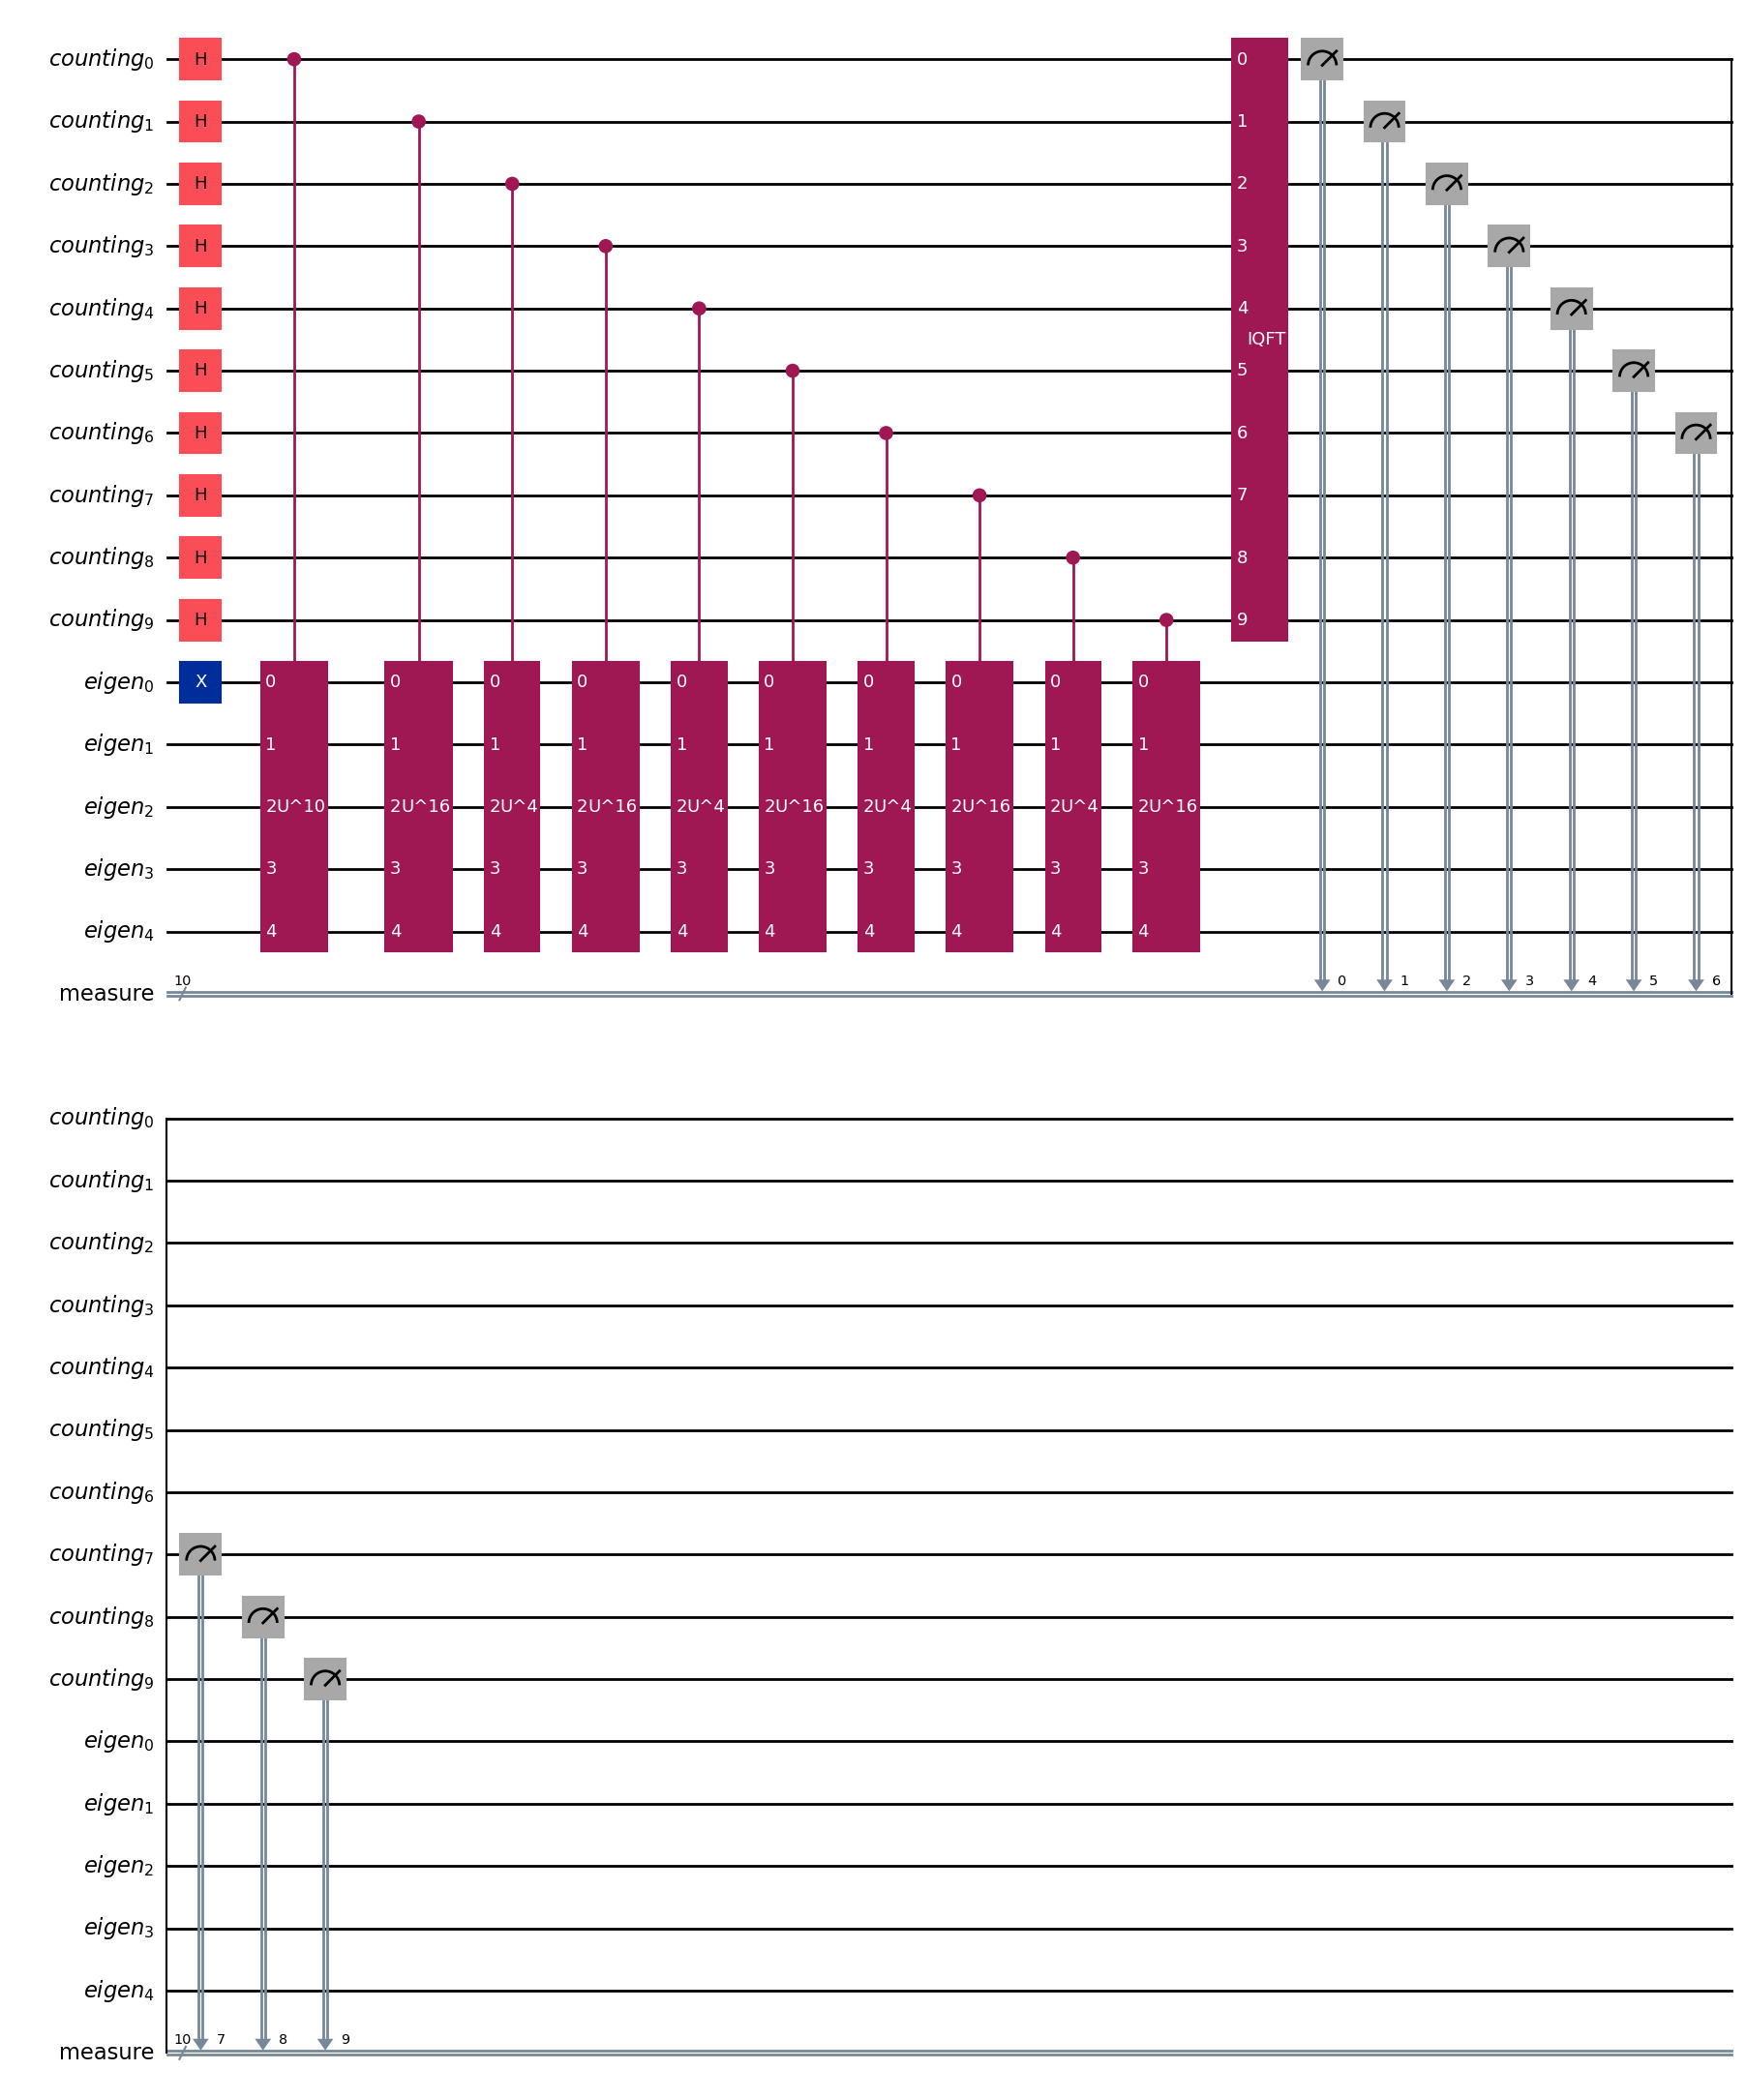

In [10]:
qc_out = quantum_phase_estimation(N, a)
print("Generated QPE circuit")
qc_out.draw(output = 'mpl')


In [11]:

try:
    counts = simulate_qpe(qc_out)
    print("Measurement results:", counts)

    r = post_process_qpe_results(counts, N, a)
    print("Period:", r)

    result = period_to_factor(N, a, r)
    print(f"Result: {result}")
except:
    print("The Simulator was not able to determine the period")



Measurement results: {'0101000110': 4, '0101010101': 3, '1011110111': 1, '1100010111': 2, '1010111101': 3, '1101000011': 1, '1101011101': 2, '1011000011': 3, '0011011011': 2, '1100110010': 1, '1011010010': 4, '1011011011': 2, '1011001100': 1, '1101001100': 2, '0101001001': 5, '1010110100': 3, '1110111010': 1, '0100010110': 2, '0100101100': 4, '1111111010': 1, '1000011010': 1, '1011000111': 1, '0000000000': 359, '0011100011': 1, '0011001010': 1, '0001111110': 1, '1110010010': 3, '0100011101': 6, '1001010011': 1, '1000111010': 4, '0100101110': 8, '0100110010': 11, '1010010011': 1, '1010110010': 2, '1101001110': 3, '1011001110': 3, '1011011101': 3, '0100010011': 1, '0001110010': 5, '1111010111': 2, '0110101011': 1, '0011000111': 2, '1110011101': 2, '0100001010': 2, '0001110011': 3, '1011111001': 2, '1100011001': 4, '0010110100': 2, '0001011010': 5, '0101000011': 3, '1101011010': 1, '1010111010': 6, '1101000110': 3, '1011000110': 5, '1110010101': 1, '0100011100': 2, '0011100100': 3, '01000

In [12]:
#select quantum backend

service = QiskitRuntimeService()
backend = service.least_busy()

print(f'Selected backend: {backend.name} with {backend.status().pending_jobs} pending jobs')

Selected backend: ibm_kyiv with 3 pending jobs


In [13]:
# transpile for the circuit for the selected backend

transpiled_qc = transpile(
    qc_out,
    backend=backend,  # Use the backend for transpilation
    optimization_level=2 # Medium-High optimization level
)

print("Transpiled")


Transpiled


In [14]:
# run the circuit

sampler = Sampler(backend)
job = sampler.run([transpiled_qc], shots=1024)

print("Job ID:", job.job_id)
print("Job status:", job.status())


Job ID: <bound method BasePrimitiveJob.job_id of <RuntimeJobV2('cyks79n9b62g0082v700', 'sampler')>>
Job status: QUEUED


In [15]:
# Get the result from execution on quantum computer

pub_result = job.result()[0]
quasi_dists = pub_result.data.measure.get_counts()  # Use 'meas' for measurement results

# Print the quasi-distribution
print("Quasi-probability distribution:", quasi_dists)


Quasi-probability distribution: {'1100000111': 5, '1110000000': 1, '0111001001': 2, '0000100100': 4, '0110000011': 3, '0011011011': 1, '1100100111': 3, '0111000001': 1, '0110101011': 2, '1111011010': 2, '1100011100': 2, '1110100001': 2, '1010000011': 4, '1001011000': 2, '1101010100': 1, '1000011011': 3, '1011111111': 1, '1101011011': 1, '0000000010': 1, '1000111001': 1, '1100010000': 3, '0000011000': 3, '1001010010': 3, '1101110011': 3, '0100000100': 2, '0110101111': 2, '1111011000': 3, '0101001110': 2, '1101111000': 5, '0001000001': 2, '1001010110': 2, '0101110101': 2, '1010110000': 2, '1111001101': 3, '0010111111': 2, '1011101111': 2, '0010111100': 2, '0111101000': 3, '0011000011': 2, '1100000100': 3, '1111111001': 2, '0000100101': 2, '1110101100': 2, '1010000010': 2, '1100100101': 1, '1000000010': 1, '1101001001': 2, '0000101100': 1, '1010000111': 2, '0001101001': 2, '1010110110': 2, '1011111110': 2, '0110010101': 4, '0100111001': 2, '0000110111': 1, '0101100011': 2, '0001110001': 2

In [16]:
r = post_process_qpe_results(quasi_dists, N, a)
print("Period:", r)

factors = period_to_factor(N, a, r)
print(f"Result: {factors}")

Period: 78
Result: (7, 3)


In [17]:

def qft_subtractor(num_qubits: int, N: int) -> QuantumCircuit:
    """
    Implements the inverse QFT for subtraction.
    |x⟩ → |x - N⟩
    """

    qr_x = QuantumRegister(num_qubits, 'x')
    qc = QuantumCircuit(qr_x, name='QFTSub')
    
    # Apply QFT
    qc.append(QFT(num_qubits, do_swaps=False).to_gate(), qr_x[:])
    
    # Apply phase rotations for subtraction
    for i in range(num_qubits):
        for j in range(i + 1):
            if (N >> j) & 1:  # if jth bit of N is 1
                # Calculate phase for position
                phase = (2 * np.pi * (2 ** (j)) / (2 ** (num_qubits))) * (2 ** (num_qubits - 1 - i))
                phase = phase % (2 * np.pi)
                if phase != 0:
                    # Note: We use negative phases for subtraction
                    qc.p(-phase, qr_x[i])

    # Apply inverse QFT
    qc.append(QFT(num_qubits, do_swaps=False, inverse=True).to_gate(), qr_x[:])
    
    return qc

def quantum_doubler(num_qubits: int) -> QuantumCircuit:
    """
    Creates a circuit that doubles the input value using QFT
    |x⟩ → |2x⟩
    
    Args:
        num_qubits: Number of qubits in register
    
    Returns:
        QuantumCircuit: Circuit implementing doubling operation
    """
    qr_x = QuantumRegister(num_qubits + 1, 'x')

    qc = QuantumCircuit(qr_x, name='QFTDouble')
    
    # Copy the state |x> into |2x>
    for i in range(num_qubits, 0, -1):
        qc.cx(i - 1, i)
        qc.cx(i, i - 1)
    
    return qc

def modular_doubler(num_state_qubits, N) -> QuantumCircuit:
    """
    Implements |x⟩ → |(2x) mod N⟩ using bit shifts and modular reduction.
    """

    qr_x = QuantumRegister(num_state_qubits, 'x') # State qubits + 1 for ancilla
    qr_double_ancilla = QuantumRegister(1, 'double_ancilla')
    qr_comp_ancilla = QuantumRegister(num_state_qubits + 1, 'comp_ancilla')
    qc = QuantumCircuit(qr_x, qr_double_ancilla, qr_comp_ancilla, name='ModDbl')
    
    # Double the input
    qc.append(quantum_doubler(num_state_qubits).to_gate(), qr_x[:] + qr_double_ancilla[:])
    
    # Modular reduction: If result >= N, subtract N
    cmp = IntegerComparator(num_state_qubits + 1, N, geq=True).to_gate()
    qc.append(cmp, qr_x[:] + qr_double_ancilla[:] + qr_comp_ancilla[:])

    qft_sub = qft_subtractor(num_state_qubits + 1, N).to_gate().control(1)
    qc.append(qft_sub, [qr_comp_ancilla[0]] + qr_x[:] + qr_double_ancilla[:])

    # Uncompute the comparator
    #qc.append(cmp.inverse(), qr_x[:] + qr_double_ancilla[:] + qr_comp_ancilla[:])
    
    return qc



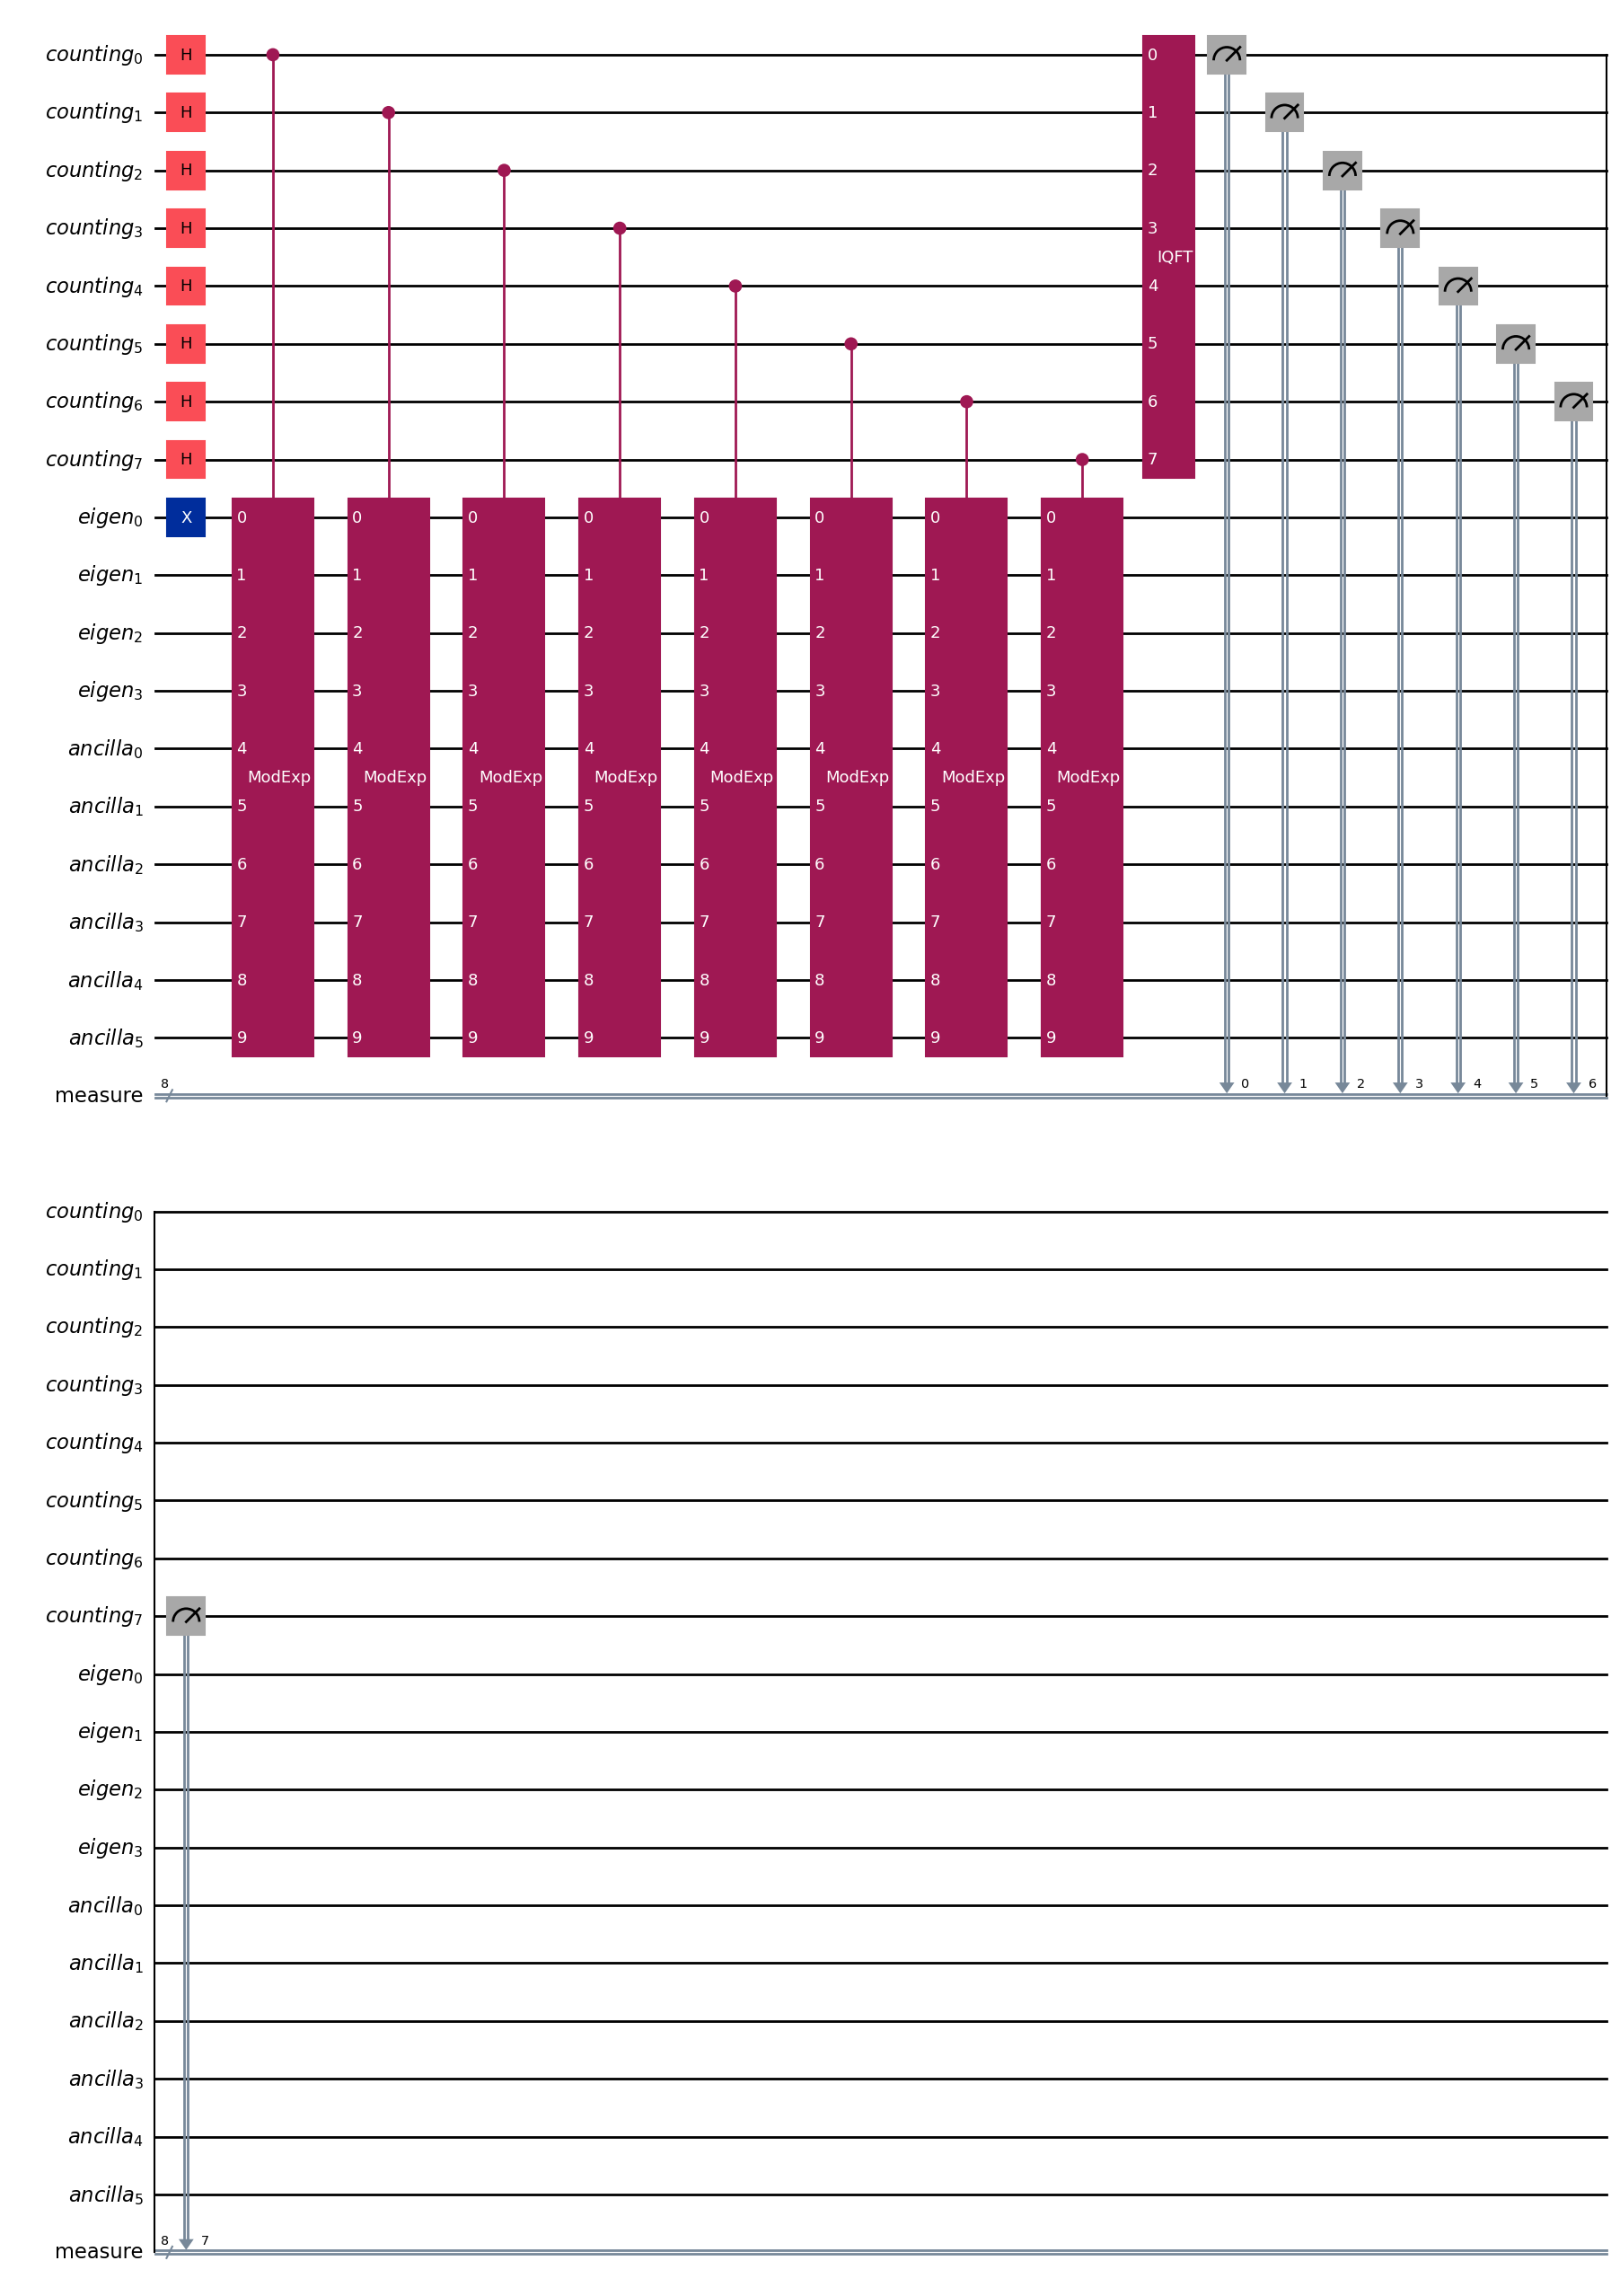

In [18]:
def mod_exp_a_2(num_qubits: int, power: int, N: int) -> QuantumCircuit:
    """
    Implements |x⟩ → |2^(2^power) * x mod N⟩ using controlled modular doubling.
    """

    qr = QuantumRegister(2 * num_qubits + 2, 'qr')
    qc = QuantumCircuit(qr, name='ModExp')

    # Apply controlled modular doubling
    mod_dbl = modular_doubler(num_qubits, N).to_gate()
    for _ in range(power):
        qc.append(mod_dbl, qr[:])

    return qc

def phase_estimation_a_2(N):
    """
    Performs phase estimation for controlled modular exponentiation.
    """
    m = ceil(log2(N))

    n_counting = 2 * m  # Increased precision

    # Quantum registers
    qr_counting = QuantumRegister(n_counting, 'counting')
    qr_eigen = QuantumRegister(m, 'eigen')
    qr_ancilla = QuantumRegister(m + 2, 'ancilla')
    cr_measure = ClassicalRegister(n_counting, 'measure')
    qc = QuantumCircuit(qr_counting, qr_eigen, qr_ancilla, cr_measure)

    # Initialize eigenstate to |1>
    qc.x(qr_eigen[0])

    # Apply Hadamard gates to counting qubits
    qc.h(qr_counting)

    # Apply controlled-U^(2^i) operations
    # Controlled modular doubling operations
    for i in range(n_counting):
        power_mod_mul = mod_exp_a_2(m, 2**i, N)
        qc.append(power_mod_mul.to_gate().control(1), [qr_counting[i]] + qr_eigen[:] + qr_ancilla[:])

    # Apply inverse Quantum Fourier Transform
    qft_dagger = QFT(num_qubits=n_counting, inverse=True, insert_barriers=True)
    qc.append(qft_dagger, qr_counting)

    # Measure only the counting qubits
    qc.measure(qr_counting, cr_measure)
    
    return qc

qc = phase_estimation_a_2(15)
qc.draw(output = 'mpl')

In [19]:
quasi_dists = simulate_qpe(qc)
print(quasi_dists)

{'11100101': 16, '10011010': 3, '00110111': 41, '00000000': 32, '00101100': 2, '10011011': 17, '01110000': 2, '10010010': 34, '11110111': 32, '00010010': 30, '10100101': 11, '11100011': 2, '01000000': 36, '10100011': 1, '01110110': 2, '11010011': 7, '00100101': 18, '10000000': 30, '10101110': 38, '10010001': 2, '11101110': 24, '00011011': 17, '10001001': 37, '01011010': 6, '00001001': 30, '01100100': 13, '00100111': 2, '11000000': 48, '10110111': 29, '01011011': 21, '10010101': 2, '11010010': 29, '00100100': 16, '01110111': 40, '01010010': 29, '01001001': 28, '11011100': 8, '00101110': 24, '01010011': 2, '00011001': 2, '01101110': 30, '01100101': 17, '01100001': 1, '00101101': 1, '00110011': 3, '11011011': 22, '11101101': 6, '10101111': 1, '10100100': 9, '10010011': 3, '01101111': 2, '01010001': 2, '11011010': 2, '01100011': 2, '00011111': 3, '10001000': 1, '00011100': 16, '11101100': 1, '00100110': 2, '11100100': 10, '11001001': 29, '01010100': 3, '10110001': 2, '01011101': 3, '100111

In [20]:
r = post_process_qpe_results(quasi_dists, 15, 2)
print("Period:", r)

factors = period_to_factor(15, 2, r)
print(f"Result: {factors}")

Period: 4
Result: (5, 3)
